## Movie Review Validation

This notebook builds on previous work done on the sentiment analysis of movie reviews.  the dataset come from 
- http://www.cs.cornell.edu/people/pabo/movie-review-data

This data consists of unprocessed, unlabeled html files from the IMDb archive of the rec.arts.movies.reviews newsgroup.  

This notebook:
- Cleans and processes the movie reviews text
- takes the processesed negtive and positive movie reviews adds labels (0/1)
- tokenizes the reviews and splits into training validation sets
- builds a neural network model
- compares traing and validation results
- applies the model to new test data

In [291]:
import string
import re
from os import listdir
from numpy import array
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
import random
from keras.layers import Dropout
from keras import losses
from keras import metrics

# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# turn a doc into clean tokens
def clean_doc(doc):
    # split into tokens by
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

# load doc, clean and return line of tokens
def doc_to_line(filename, vocab):
    # load the doc
    doc = load_doc(filename)
    # clean doc
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [w for w in tokens if w in vocab]
    return ' '.join(tokens)

# load all docs in a directory
def process_docs(directory, vocab):
    lines = list()
    # walk through all files in the folder
    for filename in listdir(directory):
        # create the full path of the file to open
        path = directory + '/' + filename
        # load and clean the doc
        line = doc_to_line(path, vocab)
        # add to list
        lines.append(line)
    return lines

# load and clean a dataset
def load_clean_dataset(vocab):
    neg_array = []
    pos_array = []    
    # load documents
    neg = process_docs('data/txt_sentoken/neg', vocab)
    pos = process_docs('data/txt_sentoken/pos', vocab)
    
    #make seperate lists for neg and pos with associated labels

    neg_array = [(review,0) for review in neg]
    pos_array = [(review,1) for review in pos]
        
    return neg_array,pos_array

In [292]:
# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())

In [293]:
#get lists of neg and pos reviews
neg,pos = load_clean_dataset(vocab)

In [294]:
#combine the reviews then randomly shuffle 
neg_pos_reviews = neg+pos
random.shuffle(neg_pos_reviews)

In [295]:
#seperate out the matching reviews and labels
x_train = []
y_train = []
for review,label in neg_pos_reviews:
    x_train.append(review)
    y_train.append(label)

At this point we have the reviews and and matching labels

In [296]:
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [297]:
tokenizer = create_tokenizer(x_train)

In [298]:
#split into train and validation sets
Xtrain = x_train[:1500]
Xval = x_train[1500:]

ytrain = y_train[:1500]
yval = y_train[1500:]

In [299]:
# encode data into integer values
Xtrain = tokenizer.texts_to_matrix(Xtrain, mode='binary')
Xval = tokenizer.texts_to_matrix(Xval, mode='binary')

Different model parameters were tried all giving simlar results

In [300]:
# define the model
def define_model(n_words):
    # define network
    model = Sequential()
    model.add(Dense(16, input_shape=(n_words,), activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile network
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    # summarize defined model
    model.summary()
    #plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [301]:
# define network
n_words = Xtrain.shape[1]
model = define_model(n_words)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 16)                236880    
_________________________________________________________________
dense_58 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 9         
Total params: 237,025
Trainable params: 237,025
Non-trainable params: 0
_________________________________________________________________


In [302]:
history = model.fit(Xtrain,ytrain,epochs=10,validation_data = (Xval,yval),verbose=1)
model.fit(Xtrain,ytrain,epochs=20,validation_data = (Xval,yval),verbose=0)

Train on 1500 samples, validate on 500 samples
Epoch 1/10
1500/1500 [==============================] - 1s 536us/step - loss: 0.5433 - acc: 0.7393 - val_loss: 0.3969 - val_acc: 0.8420
Epoch 2/10
1500/1500 [==============================] - 0s 280us/step - loss: 0.1892 - acc: 0.9667 - val_loss: 0.3246 - val_acc: 0.8760
Epoch 3/10
1500/1500 [==============================] - 0s 253us/step - loss: 0.0530 - acc: 0.9980 - val_loss: 0.2928 - val_acc: 0.8820
Epoch 4/10
1500/1500 [==============================] - 0s 254us/step - loss: 0.0137 - acc: 1.0000 - val_loss: 0.3196 - val_acc: 0.8760
Epoch 5/10
1500/1500 [==============================] - 0s 259us/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.3609 - val_acc: 0.8780
Epoch 6/10
1500/1500 [==============================] - 0s 243us/step - loss: 9.8137e-04 - acc: 1.0000 - val_loss: 0.4123 - val_acc: 0.8760
Epoch 7/10
1500/1500 [==============================] - 0s 266us/step - loss: 3.3191e-04 - acc: 1.0000 - val_loss: 0.4722 - val_acc: 

In [303]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

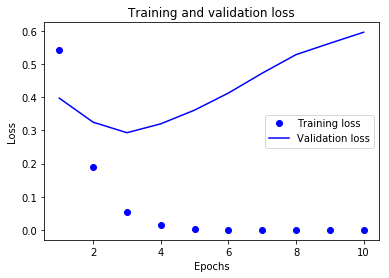

In [304]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

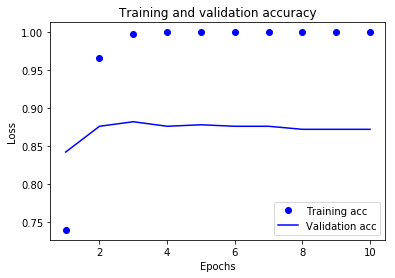

In [305]:
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The training loss decreases with every epoch and the training accuracy increases with evry epoch - this should be expected as running gradient descent optimisation.  But validation loss and accuracy peak very early - overfitting.

In [306]:
# classify a review as negative or positive
def predict_sentiment(review, vocab, tokenizer, model):
    # clean
    tokens = clean_doc(review)
    # filter by vocab
    tokens = [w for w in tokens if w in vocab]
    # convert to line
    line = ' '.join(tokens)
    # encode
    encoded = tokenizer.texts_to_matrix([line], mode='binary')
    # predict sentiment
    yhat = model.predict(encoded, verbose=0)
    # retrieve predicted percentage and label
    percent_pos = yhat[0,0]
    if round(percent_pos) == 0:
        return (1-percent_pos), 'NEGATIVE'
    return percent_pos, 'POSITIVE'

In [307]:
# test positive text\\
reviews =['Best movie ever! It was great, I recommend it.','This is a bad movie.','I thought this movie was ok',
'It was the worst movie I have ever seen, what a load of rubbish','Really good movie! I loved it']

for review in reviews:
    percent, sentiment = predict_sentiment(review, vocab, tokenizer, model)
    print('Review: [%s]\nSentiment: %s (%.3f%%)' % (review, sentiment, percent*100))
    print('\n')


Review: [Best movie ever! It was great, I recommend it.]
Sentiment: POSITIVE (52.849%)


Review: [This is a bad movie.]
Sentiment: NEGATIVE (85.666%)


Review: [I thought this movie was ok]
Sentiment: NEGATIVE (66.672%)


Review: [It was the worst movie I have ever seen, what a load of rubbish]
Sentiment: NEGATIVE (92.841%)


Review: [Really good movie! I loved it]
Sentiment: POSITIVE (67.818%)




## Dropout
Dropout is a regularization technique for neural network models. Dropout is a technique where randomly selected neurons are ignored during training. They are dropped-out randomly.  Is a form of regularisation - may help with overfitting

First try Dropout on visible layer

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_4 (Dropout)          (None, 14804)             0         
_________________________________________________________________
dense_60 (Dense)             (None, 16)                236880    
_________________________________________________________________
dense_61 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 9         
Total params: 237,025
Trainable params: 237,025
Non-trainable params: 0
_________________________________________________________________
Train on 1500 samples, validate on 500 samples
Epoch 1/10
1500/1500 [==============================] - 1s 557us/step - loss: 0.5789 - acc: 0.7180 - val_loss: 0.4331 - val_acc: 0.8460
Epoch 2/10
1500/1500 [==============================] - 0s 269us/step - loss: 0.2360 

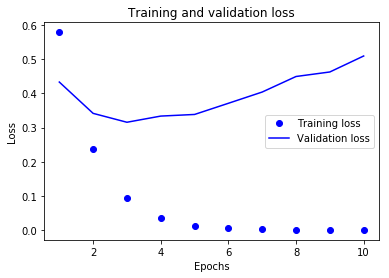

In [308]:
# define the model
def define_model(n_words):
    # define network
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(n_words,)))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile network
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    # summarize defined model
    model.summary()
    #plot_model(model, to_file='model.png', show_shapes=True)
    return model

# define network
n_words = Xtrain.shape[1]
model = define_model(n_words)

#fit the model
history = model.fit(Xtrain,ytrain,epochs=10,validation_data = (Xval,yval),verbose=1)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

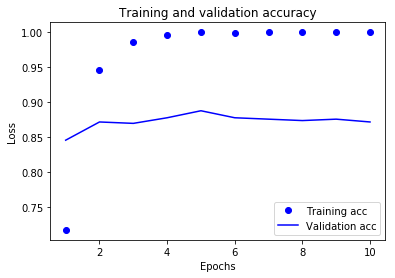

In [309]:
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Dropout on hidden layers

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 16)                236880    
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_64 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 9         
Total params: 237,025
Trainable params: 237,025
Non-trainable params: 0
_________________________________________________________________
Train on 1500 samples, validate on 500 samples
Epoch 1/10
1500/1500 [==============================] - 1s 567us/step - loss: 0.5743 - acc: 0.7233 - val_loss: 0.4381 - val_acc: 0.8620
Epoch 2/10
1500/1500 [==============================] - 0s 261us/step - loss: 0.2520 

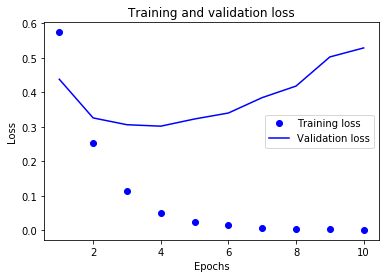

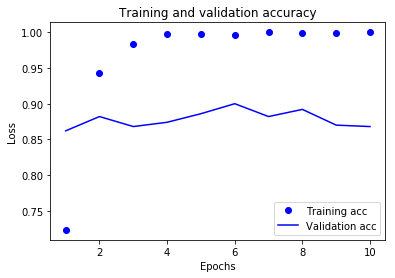

In [310]:
# define the model
def define_model(n_words):
    # define network
    model = Sequential()
    model.add(Dense(16, input_shape=(n_words,), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile network
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    # summarize defined model
    model.summary()
    #plot_model(model, to_file='model.png', show_shapes=True)
    return model

# define network
n_words = Xtrain.shape[1]
model = define_model(n_words)

#fit the model
history = model.fit(Xtrain,ytrain,epochs=10,validation_data = (Xval,yval),verbose=1)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Trying with some new test data

In [311]:
# test positive text\\
reviews =['Best movie ever! It was great, I recommend it.','This is a bad movie.','I thought this movie was ok',
'It was the worst movie I have ever seen, what a load of rubbish','Really good movie! I loved it']

for review in reviews:
    percent, sentiment = predict_sentiment(review, vocab, tokenizer, model)
    print('Review: [%s]\nSentiment: %s (%.3f%%)' % (review, sentiment, percent*100))
    print('\n')


Review: [Best movie ever! It was great, I recommend it.]
Sentiment: POSITIVE (71.019%)


Review: [This is a bad movie.]
Sentiment: NEGATIVE (59.114%)


Review: [I thought this movie was ok]
Sentiment: POSITIVE (53.689%)


Review: [It was the worst movie I have ever seen, what a load of rubbish]
Sentiment: NEGATIVE (75.554%)


Review: [Really good movie! I loved it]
Sentiment: POSITIVE (73.443%)


